# Goal: Find drivers of upsets in chess games and create a model to predict upsets 

* Upset is defined as a player with a lower rating winning a game agenst a player with a higher rating
* Model should make a predictions after having 'interviewed' each player as to thier intended opening as white and what defence they intend to use against a given opening as black

### Initial Thoughts

<br>

* Going into this project I am of two minds.

<br>

**First**
* Chess is a skill based game with no random elements (except assigning first move). 
* Because of this the player with the highest level of skill will win any game not determined by variation in player performance. 
* Because of this a given game will be won by the player with the highest level of skill a large majority of the time.
* If this is true conditions underwhich variation in performance is the highest should result in the highest likelyhood of an upset.

<br>

**Second**
* It may also be the case that more skilled players are able to maintain consistancy better than less skilled players under conditions that would increased variation in thier performance.
* If this is true, those conditions may make upsets less likely as the variance would have a grater effect on the the less skilled player than on the more skilled player.

<br>

**Moving Forward**
* Though these two schools of thought may point at differing conclutions, both seem grounded in reason and I am eager to see what the data can tell us

### Initial Hypothisese About Drivers

* There will be few instances of upsets, possibly leading to an imbalanced data set
* As ratings for both players increase, the likelyhood of an upset will decrease 
* As the margin between player ratings increase the likelyhood of an upsets will decrease
* Shorter time incraments will increase the likelyhood of an upset
* Unranked games will have a higher likelyhood of an upset than ranked games
* Games where the higher rated player is moving the white pieces (gaining first move advantage) will have a decreased likelyhood of of an upset
* Some opening/defense stratagies may be more or less prone to upsets
* openings/defences that are more popular or perfered by higher rated players may be more/less prone to upset

# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

from scipy import stats
import re

import wrangle as w

# Acquire

* Data acquired from Kaggle at https://www.kaggle.com/datasnaek/chess
* It contained 20,058 rows and 9 columns before cleaning
* Each row represents a chess game played on Lichess.org
* Each column represents a feature of those games

# Prepare

**Data was very clean initially, I performed the following steps to insure that is was ready for exploration:**
* Removed columns that did not contain useful information
* Renamed columns to premote readability
* Checked for nulls in the data (there were none)
* Checked that column data types were apropriate
* Removed white space from values in object columns
* There were no rows lost during preperation
* Added Target column 'upset' indicating weather the lower rated player won the game
* Added additional features to investigate
* Split data into train, validate and test (approx. 60/20/20), stratifying on 'upset'
* Outliers have not been removed for this itteration of the project

# Data Dictionary

| Feature | Definition |
|:--------|:-----------|
|Rated| True or False, The game's result is reflected in each player's rating|
|Winning Pieces| The color of pieces the winning player was moving|
|White Rating| Rating of the player moving the white pieces using the Glicko-2 rating method for games played on Lichess|
|Black Rating| Rating of the player moving the white pieces using the Glicko-2 rating method for games played on Lichess|
|Rating Difference| The difference in rating between the players in the game|
|Game Rating| The average rating of the two players in the game|
|Lower Rated White| True or False, The lower rated player is moving the white pieces|
|Opening Name| The name of the opening played in the game|
|Time Control Group| The amount of time aloted to each player to make their moves, **Standard** (60 min or more), **Rapid** (30 - 15 min), **Blitz** (5 - 3 min), or **Bullet** (2 or less), **Other** (any other time limit)|
|Upset (Target)| True or False, The lower rated player won the game|



In [2]:
# acquiring, cleaning, and adding pre-split features to data
df = w.wrangle_chess_data(reprep = True)

# Splitting data into train, validate, and test
train, validate, test = w.split_my_data(df)

# Explore

## How often do upsets occur?

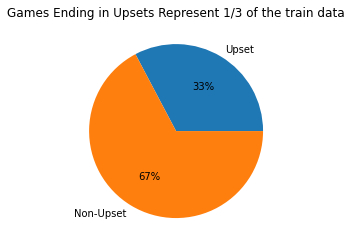

In [3]:
values = [len(train.upset[train.upset == True]), len(train.upset[train.upset == False])] 
labels = ['Upset','Non-Upset', ] 
plt.pie(values, labels=labels, autopct='%.0f%%')
plt.title('Games Ending in Upsets Represent 1/3 of the train data')
plt.show()

**About 1/3 of games will end in an upset** <br>
This is much higher than I expected and may be do to the Lichess.org matching system pairing similarly rated players for matches.

## Dose first turn advantage effect upsets?

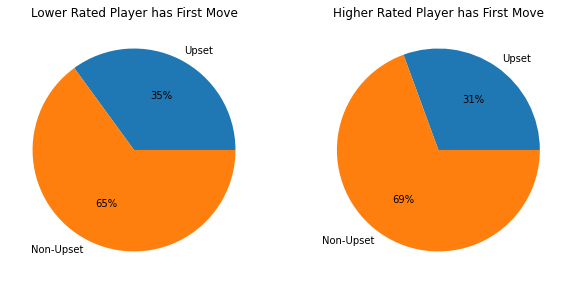

In [4]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))
#fig.suptitle('Upset Percentage is 4% Higher in Games Where the Lower Rated Player has the First Move')

values = [len(train.upset[(train.lower_rated_white == True) & (train.upset == True)]),
          len(train.upset[(train.lower_rated_white == True) & (train.upset == False)])]
labels = ['Upset', 'Non-Upset']

ax1.pie(values, labels=labels, autopct='%.0f%%')
ax1.title.set_text('Lower Rated Player has First Move')

values = [len(train.upset[(train.lower_rated_white == False) & (train.upset == True)]),
          len(train.upset[(train.lower_rated_white == False) & (train.upset == False)])]
labels = ['Upset', 'Non-Upset'] 

ax2.pie(values, labels=labels, autopct='%.0f%%')
ax2.title.set_text('Higher Rated Player has First Move')

plt.show()

**Upset Percentage is 4% Higher in Games Where the Lower Rated Player has the First Move.** <br>
This is lower than I expected.

 I will now use a chi-square test to investigate whether this pattern will hold for the total population of chess games.

**Ho: "Games ending in Upset" and "The lower ranked player having the first move" are independant of one another.** 

**Ha: "Games ending in Upset" and "The lower ranked player having the first move" are dependant on one another.**

**I will be using a confidance level of 95% resulting an an alpha of .05.**

In [5]:
observed = pd.crosstab(train.lower_rated_white, train.upset)

chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

chi^2 = 24.9953
p     = 0.0000


**Because our P value is grater than our alpha we have sufficient evidence to support that "Games ending in Upset" and "The lower ranked player having the first move" are dependant on one another. For that reason, I believe that "lower rated player has fist move" is a benificial feature to model on.**

## Does a game being rated effect upsets?

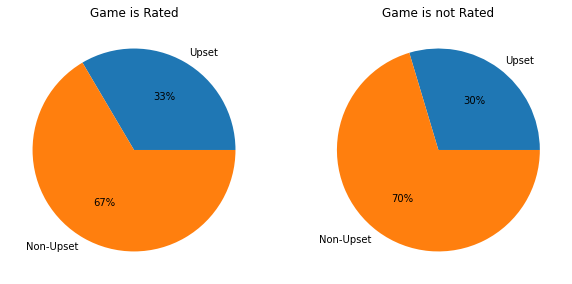

In [6]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))
#fig.suptitle('Upset Percentage is 4% Higher in Games Where the Lower Rated Player has the First Move')

values = [len(train.upset[(train.rated == True) & (train.upset == True)]),
          len(train.upset[(train.rated == True) & (train.upset == False)])]
labels = ['Upset', 'Non-Upset']

ax1.pie(values, labels=labels, autopct='%.0f%%')
ax1.title.set_text('Game is Rated')

values = [len(train.upset[(train.rated == False) & (train.upset == True)]),
          len(train.upset[(train.rated == False) & (train.upset == False)])]
labels = ['Upset', 'Non-Upset'] 

ax2.pie(values, labels=labels, autopct='%.0f%%')
ax2.title.set_text('Game is not Rated')

plt.show()

**Upset percentage is 3% higher in games that are rated.** <br>
I would have guessed that rated games had fewer upsets, but that seems not to be the case. <br>

I wil now use a chi-square test to see if this patern is likely to hold for the entire population of chess games

**Ho: "Game is rated" and "Game ended in Upset" are independant of one another.** 

**Ha: "Game is rated" and "Game ended in Upset" are dependant of one another.**

**I will be using a confidance level of 95% resulting an an alpha of .05.**

In [7]:
observed = pd.crosstab(train.rated, train.upset)

chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

chi^2 = 11.7329
p     = 0.0006


**Because our P value is less than our alpha we can conclude that there is a high likelyhood that "Games ending in Upset" and "Game is rated" are dependant on one another. For this reason I expect to see the same 3% difference observed in our sampe to be reflected in the total population of chess games. For that reason, I believe that "Game is rated" is a benificial feature to model on.**

## Does player rating have an effect on upsets?
I will examine two subquestions to answer this question.

### 1) Does game rating (The average rating of both players in a game) have an effect on upsets? 

In [8]:
game_rating_upsets = train.game_rating[(train.upset == True)].mean()
print("Average game rating for upsets: ", game_rating_upsets)

Average game rating for upsets:  1586.695403861844


In [9]:
game_rating_nonupsets = train.game_rating[(train.upset == False)].mean()
print("Average game rating for non-upsets: ", game_rating_nonupsets)

Average game rating for non-upsets:  1592.3438782263402


**The average game rating for games that are upsets is slightly higher than the average game rating for games that are not upsets.** 

I will now use a t-test to see if this pattern will hold for the full population of chess games.

**HO: The mean game rating of games ending in upset is not significantly differint from the mean game rating of games not ending in an upset.**

**HA: The mean game rating of games ending in upset is significantly differint from the mean game rating of games not ending in an upset.** 

**I will be using a confidance level of 95% resulting an an alpha of .05.**

Variance of subgroups is sufficiantly similar to use a T-test.

In [10]:
print(train.game_rating[(train.upset == False)].var())
print(train.game_rating[(train.upset == True)].var())

70933.43905273586
64131.140057759905


In [11]:
stats.ttest_ind(train.game_rating[(train.upset == True)], train.game_rating[(train.upset == False)], equal_var=True)

Ttest_indResult(statistic=-1.071684204242657, pvalue=0.28388492819717703)

**Because our p-value is higher than our alpha we do not have sufficient evidence to expect the difference in game rating, seen in our sample, to be reflected in the full population of chess games. For this reason game rating would be a poor feature to model on.**

### 2) Does difference in player rating have an effect on upsets?

In [12]:
player_diff_upset = train.rating_difference[(train.upset == True)].mean()
print("Average difference in player rating for upsets: ", player_diff_upset)

Average difference in player rating for upsets:  117.97008430785966


In [13]:
player_diff_nonupset = train.rating_difference[(train.upset == False)].mean()
print("Average rating difference for nonupsets: ", player_diff_nonupset)

Average rating difference for nonupsets:  199.69172733289213


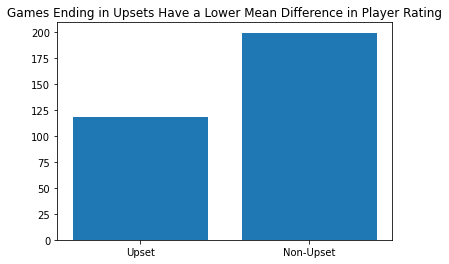

In [14]:
values = [train.rating_difference[(train.upset == True)].mean(),train.rating_difference[(train.upset == False)].mean()]
labels = ['Upset','Non-Upset', ] 
plt.bar(height=values, x=labels)
plt.title('Games Ending in Upsets Have a Lower Mean Difference in Player Rating')
plt.show()

**The average difference in player rating is 82 points lower in games ending in upset.**

**Because the data is not normally distributed I cannot use a t-test for significants. However, the shape of the data in each subgroup is the same. So I will use a Mann–Whitney test instead.**

**HO: The mean difference in player rating of games ending in upset is not significantly differint from the mean difference in player rating of games not ending in an upset.**

**HA: The mean difference in player rating of games ending in upset is significantly differint from the mean difference in player rating of games not ending in an upset.**

**I will be using a confidance level of 95% resulting an an alpha of .05.**

In [15]:
stats.mannwhitneyu(train.rating_difference[(train.upset == True)],train.rating_difference[(train.upset == False)])

MannwhitneyuResult(statistic=10131505.0, pvalue=1.8967619337817207e-120)

**Because the p-value is less than the alpha we can conclude there is a high likelyhood that the mean rating difference of players in games ending in upset is significantly differint from the mean rating difference of players in games that end in nonupsets in the total population. Based on the sample, I expect to see the same 82 point difference in the total population. For this reason I believe that difference in player rating is a good feature to model on.**

## Does time block effect upsets?

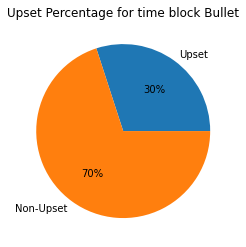

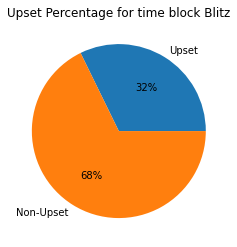

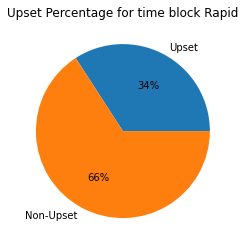

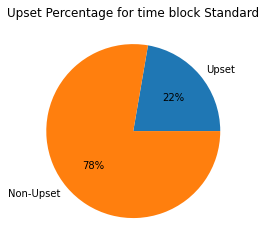

In [16]:
times = ['Bullet', 'Blitz', 'Rapid', 'Standard']

for time in times:
    
    values = [len(train.upset[(train.upset == True) & (train.time_control_group == time)]), len(train.upset[(train.upset == False) & (train.time_control_group == time)])] 
    labels = ['Upset','Non-Upset', ] 
    plt.pie(values, labels=labels, autopct='%.0f%%')
    plt.title(f'Upset Percentage for time block {time}')
    plt.show()

In time control groups where time is very limited, such as Bullet, Blitz, and Rapid games upset percentage ranges from 30 to 34 with more time seeming to trend toward a larger percentage of upsets. In Standard time control games where time is more plentaful upsets drop to 22%. Lets run a chi-square to see if the pattern we found in out sample data is likely to reflect to full popolation of chess games.

**Ho: "Games ending in Upset" and "Time Control Group" are independant of one another.** 

**Ha: "Games ending in Upset" and "Time Control Group" are dependant on one another.**

**I will be using a confidance level of 95% resulting an an alpha of .05.**

In [17]:
observed = pd.crosstab(train.time_control_group, train.upset)

chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

chi^2 = 11.5701
p     = 0.0209


Because the p-value is less than the alpha we can conclude there is a high likelyhood that "Time Control Group" and  "Games ending in upset" are dependant on one another in the total population. Based on this I expect to see the same pattern of upsets and time control group to be reflected in the total population of chess games. I belive that Time Control Group will be usefull in modeling.

# Does Opening effect upsets?

There are 1236 unique openings identified in the training data. This is far too many for a thorough examination of each. so, I will examin the top ten, by popularity, and see if they show different upset percentages. This would give evidence to show that opening is a driver of upsets.

In [18]:
len(train.opening_name.value_counts())

1236

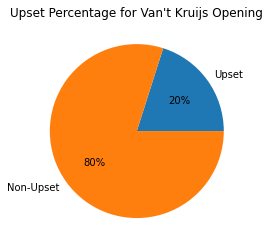

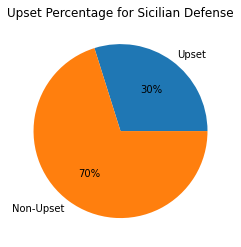

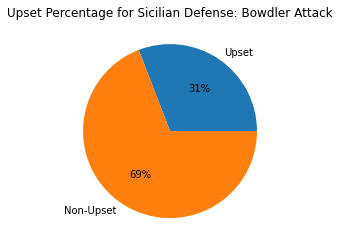

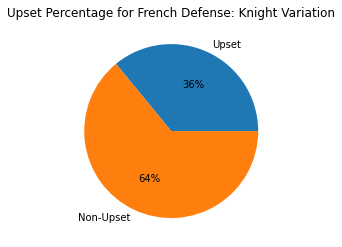

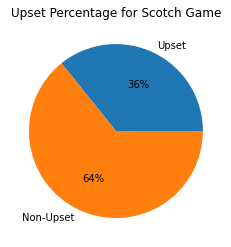

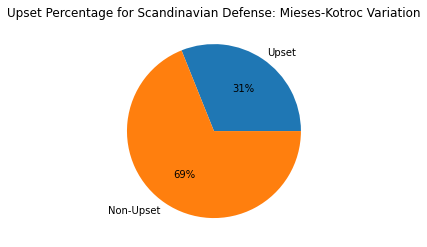

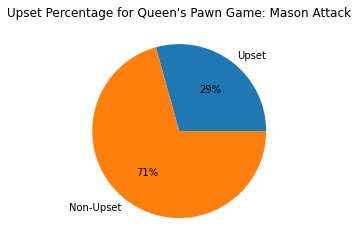

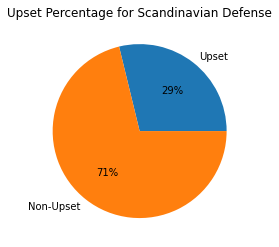

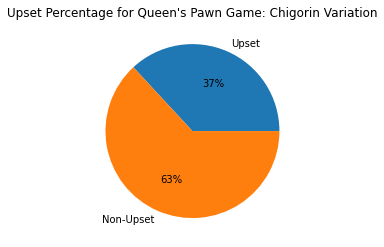

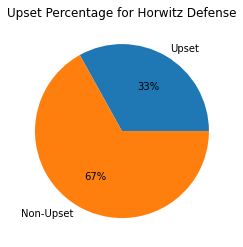

In [19]:
names = train.opening_name.value_counts().head(10).index.to_list()

for name in names:
    
    values = [len(train.upset[(train.upset == True) & (train.opening_name == name)]), len(train.upset[(train.upset == False) & (train.opening_name == name)])] 
    labels = ['Upset','Non-Upset'] 
    plt.pie(values, labels=labels, autopct='%.0f%%')
    plt.title(f'Upset Percentage for {name}')
    plt.show()

* Percentage of upsets range from 20 - 37 percent 
* Highest upset percentage was Queen's Pawn game: Chigorin Veriation at 37%
* Lowest upset percentage was Van't Kruijs Opening at 20%

The variation in upset percentages amoung openings suggest that opening is a driver of games ending in upset. I will now run a chi-square test to see if oppening and ending in upset are dependant on one another in the overall population.

**Ho: "Games ending in Upset" and "Opening" are independant of one another.** 

**Ha: "Games ending in Upset" and "Opening" are dependant on one another.**

**I will be using a confidance level of 95% resulting an an alpha of .05.**

In [20]:
observed = pd.crosstab(train.opening_name, train.upset)

chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

chi^2 = 1350.4134
p     = 0.0117


Because P is less than the Alpha we can conclude that there is a high likelyhood that ending in upset and opening are dependant on one another. For this reason I expect to see the same pattern observed in the train data reflected in the overall data. Opening is therefore useful for modeling.

# Exploration Summery

* "First turn advantage" and "game is rated" were found to be statistically significant drivers of upsets, though the amount of influance each has may be very weak. They will be used during the modeling phase
* "Difference in player rating" was found to be a statistically significant driver of "upsets." It will me used in the modeling phase
* "Time Control group" was found to be a statistically significant driver of "upsets." It will be used in the modeling phase. Being in the standard time control or not seemed to be a particularly strong driver.
* "opening" was found to be a statistically significant driver of "upsets." It will be used in the modeling phase. The Van't Kruijs Opening is the most popular oppening in the test data and is the strongest opening against upsets with a upset percentage of only 20%
</br>
* I could not find evidence to support the idea that the "average player rating" is a driver of upsets. This will not be carried over to modeling

# Modeling Prep

In [21]:
# Dropping columns not being used in modeling
train = train[['upset', 'rated', 'lower_rated_white', 'rating_difference', 'time_control_group', 'opening_name']]
validate = validate[['upset', 'rated', 'lower_rated_white', 'rating_difference', 'time_control_group', 'opening_name']]
test = test[['upset', 'rated', 'lower_rated_white', 'rating_difference', 'time_control_group', 'opening_name']]

In [22]:
# Splitting data into predicting variables (X) and target variable (y) and resetting the index for each dataframe
train_X = train.drop(columns='upset').reset_index(drop=True)
train_y = train[['upset']].reset_index(drop=True)

validate_X = validate.drop(columns='upset').reset_index(drop=True)
validate_y = validate[['upset']].reset_index(drop=True)

test_X = test.drop(columns='upset').reset_index(drop=True)
test_y = test[['upset']].reset_index(drop=True)

In [23]:
# Getting dummies for catagorical variables
train_X = pd.get_dummies(train_X,columns=['rated', 'lower_rated_white', 'time_control_group','opening_name'])
validate_X = pd.get_dummies(validate_X,columns=['rated', 'lower_rated_white', 'time_control_group','opening_name'])
test_X = pd.get_dummies(test_X,columns=['rated', 'lower_rated_white', 'time_control_group','opening_name'])

In [24]:
# Scaling continuous variables

# columns to be scaled
cols_to_scale = ['rating_difference']

# create df's for train validate and test with only columns that need to be scaled
train_to_be_scaled = train_X[cols_to_scale]
validate_to_be_scaled = validate_X[cols_to_scale]
test_to_be_scaled = test_X[cols_to_scale]

# create scaler object and fit that object on the train data
scaler = sklearn.preprocessing.MinMaxScaler().fit(train_to_be_scaled)

# transform data into an array using the scaler object 
train_scaled = scaler.transform(train_to_be_scaled)
validate_scaled = scaler.transform(validate_to_be_scaled)
test_scaled = scaler.transform(test_to_be_scaled)

# transform data into a dataframe
train_scaled = pd.DataFrame(train_scaled, columns = cols_to_scale)
validate_scaled = pd.DataFrame(validate_scaled, columns = cols_to_scale)
test_scaled = pd.DataFrame(test_scaled, columns = cols_to_scale)

# drop corresponding unscaled columns from original dataframes and reset the index
train_X = train_X.drop(columns = cols_to_scale)
validate_X = validate_X.drop(columns = cols_to_scale)
test_X = test_X.drop(columns = cols_to_scale)

# add scaled columns to their original dataframes
train_X = train_X.join(train_scaled)
validate_X = validate_X.join(validate_scaled)
test_X = test_X.join(test_scaled)

In [25]:
# Change target column to show values as upset or non-upset
train_y['upset'] = train_y.upset.apply(lambda value: "upset" if value == True else "non-upset")
validate_y['upset'] = validate_y.upset.apply(lambda value: "upset" if value == True else "non-upset")
test_y['upset'] = test_y.upset.apply(lambda value: "upset" if value == True else "non-upset")

# Modeling

I will be using accuracy as the evaluation metric. The model that has the highest percentage of accurate predictions will be considered the best model. For context we will use a baseline of blank. Because non-upsets are the most frequently occuring result and makeup about blank percent of the data it would be possible to achive a blank percent accuracy by simply guessing that a game would be a non-upset in each case. I am hopeful that my final model will improve upon this.

In [39]:
1-train.upset.mean()

0.6726317663817664

## Decision Tree

In [44]:
# create classifier object
clf = DecisionTreeClassifier(max_depth=10, random_state=123)

#fit model on training data
clf = clf.fit(train_X, train_y)

# get model accuracy for training data
print(f"Accuracy of Decision Tree is {clf.score(train_X, train_y)}")

Accuracy of Decision Tree is 0.6875890313390314


Deceision Tree's accuracy is not much higher than chance when max depth is set to resonable numbers. When set to a max_depth of as high as 10 the accuracy of the model is not much higher than the baseline. This is probable due to the large number of openings that have to be made into seperate columns making it difficult to get to the information provided by the openings without having to sak many questions. Because of this problem I am curious to see if this model will overfit if given an excessive max_depth. 

## Random Forest

## Logistic Regression

## KNN